In [41]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

In [42]:
# accessing the web page by Http request made by requests library
req = requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Chennai").text
soup = BeautifulSoup(req, 'lxml')
div = soup.find_all('table' )
print("web Page Imported")


web Page Imported


In [43]:
data = []
table = div[1]
table_body = table.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele]) # Get rid of empty values

In [44]:
df = pd.DataFrame(data,columns=['Area','Location','Latitude','Longitude'])
df

,Area,Location,Latitude,Longitude
0,None,None,None,None
1,Adambakkam,South and East Chennai,12.988,80.2047
2,Adyar,South and East Chennai,13.0012,80.2565
3,Alandur,South and East Chennai,12.9975,80.2006
4,Alapakkam,West Chennai,13.049,80.1673
...,...,...,...,...
172,Kanathur,Suburbs along ECR and OMR of Chennai,12.8663,80.2447
173,Muthukadu,Suburbs along ECR and OMR of Chennai,12.827,80.2403
174,Kelambakkam,Suburbs along ECR and OMR of Chennai,13.06042,80.24958
175,Kovalam,Suburbs along ECR and OMR of Chennai,12.787,80.2504


In [ ]:
df = df.dropna()
df['Latitude'] = df['Latitude'].apply(lambda x: float(x))
df['Longitude'] = df['Longitude'].apply(lambda x: float(x))

In [46]:
address = 'Chennai'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New Delhi are 13.0836939, 80.270186.


In [47]:
map_chennai = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Area']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)  
    
map_chennai


In [48]:
CLIENT_ID = 'PVEHZMCGQRW1UTUDAKHLC0RTRNC205YZ2NJDZDPPJOHQV5VH' # your Foursquare ID
CLIENT_SECRET = 'XYAYEPCDCHKUT44EMD25OADY1UADBPQZEGVYH0IJRDEWKW1Q' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 1000
LIMIT = 200

print('Credentails Registered')

Credentails Registered


In [49]:
def restaurentsData(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            '4d4b7105d754a06374d81259',
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area_Latitude', 
                  'Area_Longitude', 
                  'Restaurents', 
                  'Restaurents_Latitude', 
                  'Restaurents_Longitude', 
                  'Restaurents_Category']

    return(nearby_venues)

In [50]:
chennai_Data = restaurentsData(names=df['Area'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [51]:
chennai_Data.to_csv('chennai.csv')

In [52]:
chennai = pd.read_csv("chennai.csv")
chennai.head()

,Unnamed: 0,Area,Area_Latitude,Area_Longitude,Restaurents,Restaurents_Latitude,Restaurents_Longitude,Restaurents_Category
0,0,Adambakkam,12.9880,80.2047,Hotel Sai Mangalambika,12.987664,80.204269,Indian Restaurant
1,1,Adambakkam,12.9880,80.2047,Hotel Sri Raghavendra,12.985775,80.205140,South Indian Restaurant
2,2,Adambakkam,12.9880,80.2047,Shreeji Foods,12.985735,80.202530,Fast Food Restaurant
3,3,Adambakkam,12.9880,80.2047,visakan mess,12.985661,80.201748,Restaurant
4,4,Adyar,13.0012,80.2565,Domino's Pizza,13.002000,80.254000,Pizza Place


In [53]:
chennai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             756 non-null    int64  
 1   Area                   756 non-null    object 
 2   Area_Latitude          756 non-null    float64
 3   Area_Longitude         756 non-null    float64
 4   Restaurents            756 non-null    object 
 5   Restaurents_Latitude   756 non-null    float64
 6   Restaurents_Longitude  756 non-null    float64
 7   Restaurents_Category   756 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 47.4+ KB


In [54]:
chennai.describe(include='object')

,Area,Restaurents,Restaurents_Category
count,756,756,756
unique,133,576,55
top,Kelambakkam,Domino's Pizza,Indian Restaurant
freq,42,20,190


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


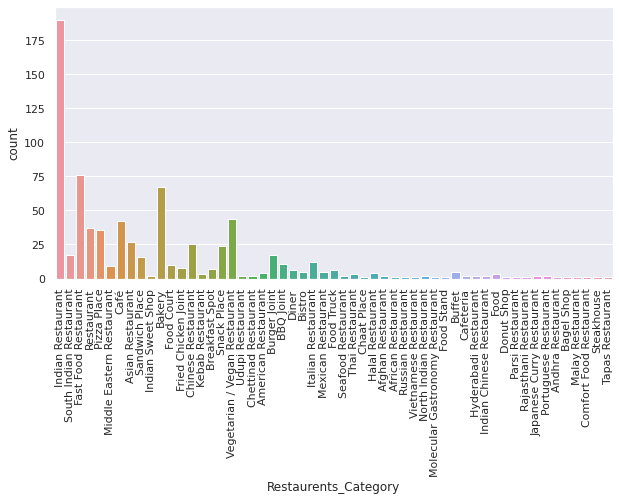

In [55]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})
chart = sns.countplot(chennai['Restaurents_Category'],orient='h')
chart.set_xticklabels(chart.get_xticklabels(),rotation=90);

In [58]:
points = np.array(chennai['Restaurents_Category']).reshape(-1,1)
encoder = OrdinalEncoder()
result = encoder.fit_transform(points).astype('int64')
chennai['Category'] = result

dummy = pd.get_dummies(chennai['Category'])
data = pd.concat([chennai['Area'], dummy],1)
data.head()

<ipython-input-58-ddcce285f537>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  data = pd.concat([chennai['Area'], dummy],1)


,Area,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adyar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
group = data.groupby('Area').mean().reset_index()
group

,Area,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,50,51,52,53,54
0,Adambakkam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.00,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.125,0.0,...,0.041667,0.0,0.00,0.041667,0.0,0.0,0.0,0.0,0.000000,0.0
2,Alandur,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Alapakkam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.20,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Alwarthirunagar,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,Villivakkam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
129,Virugambakkam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.250,0.0,...,0.000000,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0
130,Vyasarpadi,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
131,West Mambalam,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,...,0.000000,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [60]:
def return_most_common_category(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [61]:
num_top_category = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_category):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
data_sorted = pd.DataFrame(columns=columns)
data_sorted['Area'] = group['Area']

for ind in np.arange(group.shape[0]):
    data_sorted.iloc[ind, 1:] = return_most_common_category(group.iloc[ind, :], num_top_category)

data_sorted.head()

,Area,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Adambakkam,29,48,20,43,40,30,31,32,33,34
1,Adyar,29,40,7,13,16,22,43,45,25,48
2,Alandur,29,33,9,43,41,30,31,32,34,35
3,Alapakkam,29,20,47,40,30,31,32,33,34,35
4,Alwarthirunagar,20,40,53,13,29,0,31,32,33,34


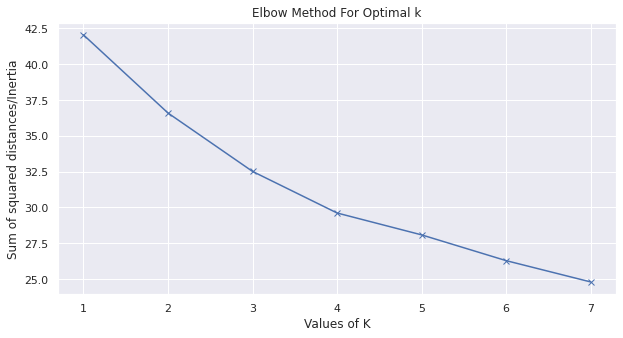

In [62]:
Sum_of_squared_distances = []
K = range(1,8)
chennai_grouped_clustering = group.drop('Area', 1)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters, random_state=0)
 kmeans.fit(chennai_grouped_clustering)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [63]:
kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)
kmeans.labels_[0:10]

<ipython-input-63-dada1ed5cb89>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  chennai_grouped_clustering = group.drop('Area', 1)


array([1, 1, 3, 0, 0, 0, 1, 1, 0, 1], dtype=int32)

In [64]:
data_sorted['Cluster Labels'] = kmeans.labels_

chennai_merged = chennai
chennai_merged = chennai_merged.join(data_sorted.set_index('Area'), on='Area')

chennai_merged.dropna(inplace=True)
chennai_merged.head()

,Unnamed: 0,Area,Area_Latitude,Area_Longitude,Restaurents,Restaurents_Latitude,Restaurents_Longitude,Restaurents_Category,Category,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category,Cluster Labels
0,0,Adambakkam,12.9880,80.2047,Hotel Sai Mangalambika,12.987664,80.204269,Indian Restaurant,29,29,48,20,43,40,30,31,32,33,34,1
1,1,Adambakkam,12.9880,80.2047,Hotel Sri Raghavendra,12.985775,80.205140,South Indian Restaurant,48,29,48,20,43,40,30,31,32,33,34,1
2,2,Adambakkam,12.9880,80.2047,Shreeji Foods,12.985735,80.202530,Fast Food Restaurant,20,29,48,20,43,40,30,31,32,33,34,1
3,3,Adambakkam,12.9880,80.2047,visakan mess,12.985661,80.201748,Restaurant,43,29,48,20,43,40,30,31,32,33,34,1
4,4,Adyar,13.0012,80.2565,Domino's Pizza,13.002000,80.254000,Pizza Place,40,29,40,7,13,16,22,43,45,25,48,1


In [66]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Area_Latitude'], chennai_merged['Area_Longitude'], chennai_merged['Area'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [67]:
dummy = pd.get_dummies(chennai['Restaurents_Category'])
data1 = pd.concat([dummy, chennai['Area']],1)

<ipython-input-67-c1f99f4ed189>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  data1 = pd.concat([dummy, chennai['Area']],1)


In [68]:
clusterdata = pd.merge(data1.groupby('Area').sum(),chennai_merged[['Area','Cluster Labels']],left_on='Area', right_on='Area',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0,1,2,3
Afghan Restaurant,0.0,8.0,0.0,0.0
African Restaurant,0.0,0.0,0.0,33.0
American Restaurant,0.0,54.0,0.0,0.0
Andhra Restaurant,0.0,28.0,0.0,0.0
Asian Restaurant,14.0,223.0,5.0,12.0


In [69]:
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(15,6)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

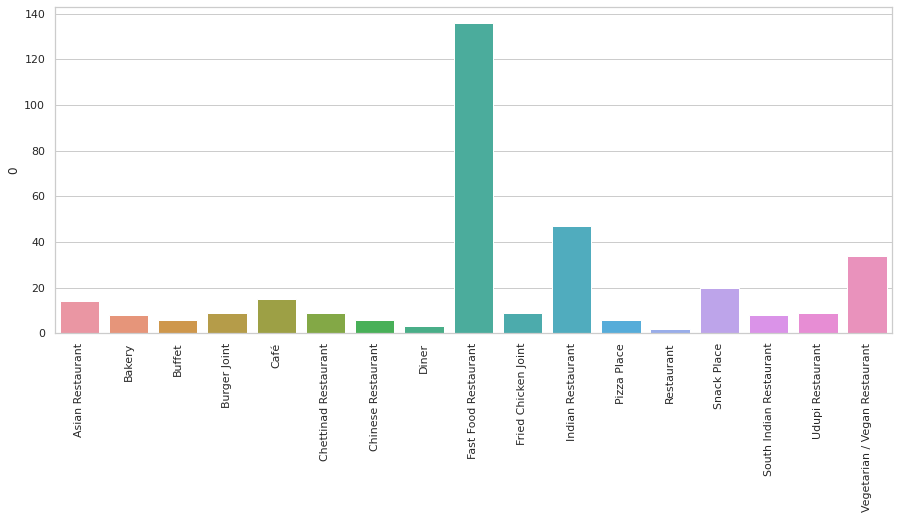

In [70]:
plot_bar(0)

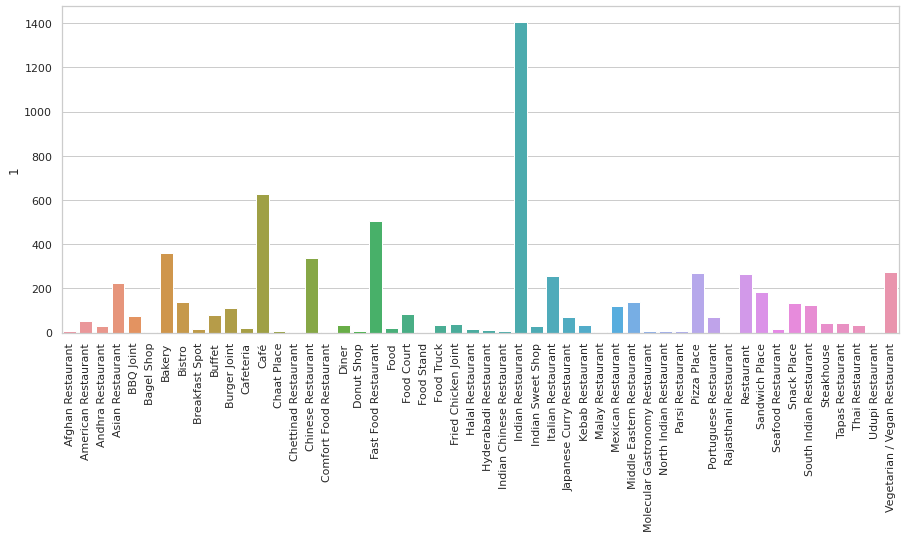

In [71]:
plot_bar(1)

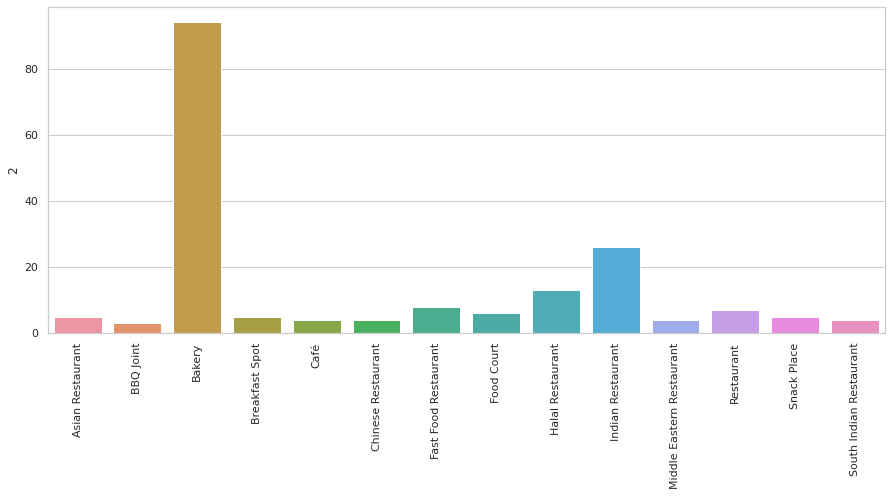

In [72]:
plot_bar(2)

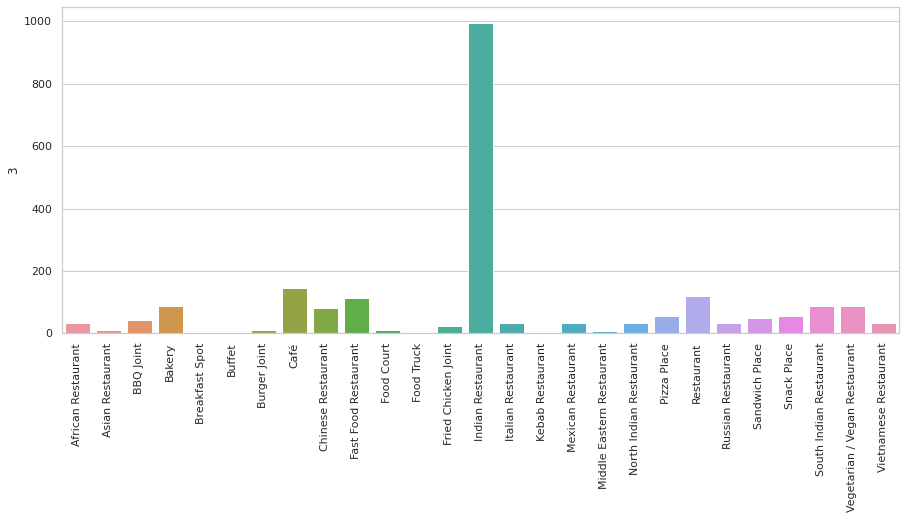

In [73]:
plot_bar(3)